# ETAPA 2b — Análise Difference-in-Differences: IA Generativa e Emprego Formal no Brasil

**Dissertação:** Inteligência Artificial Generativa e o Mercado de Trabalho Brasileiro: Uma Análise de Exposição Ocupacional e seus Efeitos Distributivos.

**Aluno:** Manoel Brasil Orlandi

**Objetivo deste notebook:** Estimar o efeito causal do lançamento da IA generativa (ChatGPT, novembro/2022) sobre o mercado de trabalho formal brasileiro, usando variação na exposição ocupacional à IA como fonte de identificação. Implementa um design Difference-in-Differences (DiD) com dados do CAGED (2021–2025) e o índice de exposição da OIT.

**Pergunta de pesquisa:** Após o lançamento do ChatGPT, ocupações mais expostas à IA generativa tiveram mudanças diferenciais em contratações, demissões ou salários de admissão, em comparação com ocupações menos expostas?

**Input:** `data/output/painel_caged_did_ready.parquet` (produzido no Notebook 2a).

**Estratégia de crosswalk:** Análise principal a 2 dígitos ISCO-08 (match por Sub-major Group com fallback a Major Group), com robustez a 4 dígitos via correspondência ISCO-88↔ISCO-08 e fallback hierárquico em 6 níveis.

**Referências metodológicas:** Hui, Reshef & Zhou (2024), *The Short-Term Effects of Generative AI on Employment*; Cunningham (2021), *Causal Inference: The Mixtape*, Cap. 9; Callaway & Sant'Anna (2021), *DiD with multiple time periods*; Gmyrek, Berg & Cappelli (2025), ILO Working Paper 140.

### Estratégia de identificação

| Elemento | Definição |
|----------|-----------|
| **Unidade de análise** | Ocupação CBO × mês (2 dígitos na espec. principal; 4 dígitos na robustez) |
| **Tratamento** | Ocupações com alta exposição à IA (top 20% do índice ILO via `exposure_score_2d`) |
| **Controle** | Ocupações com baixa exposição (bottom 80%) |
| **Evento** | Lançamento do ChatGPT (30/nov/2022) |
| **Pré-tratamento** | Jan/2021 — Nov/2022 (23 meses) |
| **Pós-tratamento** | Dez/2022 — Jun/2025 (31 meses) |
| **Outcomes** | Admissões, desligamentos, saldo, salário médio de admissão |
| **Efeitos fixos** | Ocupação (CBO 4d) + período (ano-mês) |
| **Erros padrão** | Clusterizados por ocupação (CBO 4d) |

A hipótese central é que, **na ausência do lançamento do ChatGPT**, ocupações de alta e baixa exposição teriam seguido tendências paralelas. Com **tratamento sharp** (todos tratados no mesmo momento), o estimador TWFE produz estimativas consistentes do ATT médio (Cunningham, Mixtape Cap. 9).

### Outcomes

| Outcome | Variável | Transformação | Interpretação |
|---------|----------|---------------|---------------|
| Contratações | `admissoes` | `ln_admissoes = log(admissoes + 1)` | Fluxo de novas contratações |
| Demissões | `desligamentos` | `ln_desligamentos = log(desligamentos + 1)` | Fluxo de demissões |
| Saldo líquido | `saldo` | Em nível | Criação líquida de empregos |
| Salário de admissão | `salario_medio_adm` | `ln_salario_adm = log(salario_medio_adm)` | Poder de barganha / demanda |

**Nota — Winsorização:** O Notebook 2a identificou outlier salarial em Jun/2025. Aplicamos **winsorização nos percentis 1% e 99%** de `salario_medio_adm` e `salario_sm` neste notebook antes da estimação, preservando todas as observações.

### 1. Configuração do ambiente

Importar bibliotecas, definir caminhos e parâmetros de estimação. Caminhos relativos ao diretório `notebook/`.

> **Sobre os avisos de colinearidade:** O pyfixest pode exibir *UserWarning* quando uma variável de controle (ex.: `pct_mulher_adm`) é omitida por **colinearidade** com os efeitos fixos (ocupação e período). Isso ocorre quando a variável tem pouca ou nenhuma variação dentro dos grupos. Não é erro: a estimação segue válida; o controle simplesmente não entra na regressão. Suprimimos esses avisos para deixar o notebook mais legível.

In [1]:
# Verificar dependências e instalar apenas o que faltar (rode esta célula primeiro)
import importlib.util
import subprocess
import sys

# (nome para import, nome para pip install)
PACOTES = [
    ("pandas", "pandas"),
    ("numpy", "numpy"),
    ("pyfixest", "pyfixest"),
    ("matplotlib", "matplotlib"),
    ("seaborn", "seaborn"),
    ("scipy", "scipy"),
    ("pyarrow", "pyarrow"),
]

def ja_instalado(nome_import):
    return importlib.util.find_spec(nome_import) is not None

faltando = [pip for imp, pip in PACOTES if not ja_instalado(imp)]
if faltando:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q"] + faltando)
    print("Instalado:", ", ".join(faltando))
else:
    print("Todas as dependências já estão instaladas.")

Todas as dependências já estão instaladas.


In [2]:
# Etapa 2b.1 — Configuração do ambiente

import warnings
import pandas as pd
import numpy as np
import pyfixest as pf
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

warnings.filterwarnings("ignore", category=FutureWarning)
# Suprimir aviso do pyfixest quando variável é omitida por colinearidade (ex.: pct_mulher_adm)
warnings.filterwarnings("ignore", message=".*dropped due to multicollinearity.*", category=UserWarning)

DATA_OUTPUT    = Path("data/output")
OUTPUTS_TABLES = Path("outputs/tables")
OUTPUTS_FIGURES = Path("outputs/figures")
OUTPUTS_LOGS   = Path("outputs/logs")
for d in [OUTPUTS_TABLES, OUTPUTS_FIGURES, OUTPUTS_LOGS]:
    d.mkdir(parents=True, exist_ok=True)

TREATMENT_VAR    = 'alta_exp'
TREATMENT_VAR_4D  = 'alta_exp_4d'
CLUSTER_VAR      = 'cbo_4d'
VCOV_SPEC        = {'CRV1': 'cbo_4d'}
REFERENCE_PERIOD  = -1
ALPHA             = 0.05
ANO_TRATAMENTO   = 2022
MES_TRATAMENTO   = 12

OUTCOMES = {
    'ln_admissoes':       'Log(Admissões)',
    'ln_desligamentos':   'Log(Desligamentos)',
    'saldo':              'Saldo Líquido',
    'ln_salario_adm':     'Log(Salário Admissão)',
    # Heterogeneidade demográfica (salários por grupo)
    'ln_salario_mulher':  'Log(Salário Mulheres)',
    'ln_salario_homem':   'Log(Salário Homens)',
    'ln_salario_jovem':   'Log(Salário Jovens)',
    'ln_salario_naojovem':'Log(Salário Não-Jovens)',
    'ln_salario_branco':  'Log(Salário Brancos)',
    'ln_salario_negro':   'Log(Salário Negros)',
    'ln_salario_superior':'Log(Salário Superior)',
    'ln_salario_medio':   'Log(Salário Médio)',
    'ln_admissoes_mulher':'Log(Admissões Mulheres)',
    'ln_admissoes_homem': 'Log(Admissões Homens)',
    'ln_admissoes_jovem': 'Log(Admissões Jovens)',
    'ln_admissoes_negro': 'Log(Admissões Negros)',
}
OUTCOMES_SECONDARY = {'ln_salario_sm': 'Log(Salário em SM)'}

plt.style.use('seaborn-v0_8-paper')
sns.set_palette("Set2")
plt.rcParams.update({'font.size': 11, 'axes.titlesize': 13, 'axes.labelsize': 12, 'figure.dpi': 150})
COLORS = {'pre': '#1f77b4', 'post': '#d62728', 'ci': '#cccccc', 'treated': '#ff7f0e', 'control': '#2ca02c'}

print("Configuração carregada.")

Configuração carregada.


### 2. Carregar e explorar dados

Carregar o painel produzido no Notebook 2a, aplicar winsorização P1/P99 nos salários e recalcular os logs. Em seguida, exibir estatísticas descritivas dos outcomes.

In [3]:
# Etapa 2b.2 — Carregar e explorar dados

painel_path = DATA_OUTPUT / "painel_caged_did_ready.parquet"
df = pd.read_parquet(painel_path)

print(f"Painel carregado: {len(df):,} observações")
print(f"Ocupações: {df['cbo_4d'].nunique()}")
print(f"Períodos: {df['periodo'].nunique()} meses")
print(f"Tratamento ({TREATMENT_VAR}): Alta exposição: {df[TREATMENT_VAR].mean():.1%}")
print(f"  Pré: {df[df['post']==0].shape[0]:,} obs | Pós: {df[df['post']==1].shape[0]:,} obs")

for col_sal in ['salario_medio_adm', 'salario_sm']:
    if col_sal in df.columns:
        p1, p99 = df[col_sal].quantile(0.01), df[col_sal].quantile(0.99)
        lower = max(float(p1), 0.01) if p1 <= 0 else float(p1)
        n_clip = ((df[col_sal] < lower) | (df[col_sal] > p99)).sum()
        df[col_sal] = df[col_sal].clip(lower=lower, upper=p99)
        print(f"Winsorização {col_sal}: [{lower:.2f}, {p99:.2f}], {n_clip} obs clipped")
df['ln_salario_adm'] = np.log(df['salario_medio_adm'])
df['ln_salario_sm'] = np.log(df['salario_sm'])

print("\nEstatísticas descritivas dos outcomes:")
for var, label in {**OUTCOMES, **OUTCOMES_SECONDARY}.items():
    if var in df.columns:
        print(f"  {label}: N={df[var].notna().sum():,}, média={df[var].mean():.3f}, std={df[var].std():.3f}")

Painel carregado: 32,988 observações
Ocupações: 629
Períodos: 54 meses
Tratamento (alta_exp): Alta exposição: 20.3%
  Pré: 14,058 obs | Pós: 18,930 obs
Winsorização salario_medio_adm: [0.01, 25908.75], 678 obs clipped
Winsorização salario_sm: [0.01, 20.37], 678 obs clipped

Estatísticas descritivas dos outcomes:
  Log(Admissões): N=32,988, média=5.657, std=2.291
  Log(Desligamentos): N=32,988, média=5.629, std=2.257
  Saldo Líquido: N=32,988, média=279.879, std=2322.995
  Log(Salário Admissão): N=32,988, média=7.813, std=1.426
  Log(Salário Mulheres): N=32,988, média=7.422, std=1.880
  Log(Salário Homens): N=32,988, média=7.809, std=1.302
  Log(Salário Jovens): N=32,988, média=7.511, std=1.435
  Log(Salário Não-Jovens): N=32,988, média=7.869, std=1.299
  Log(Salário Brancos): N=32,988, média=7.795, std=1.452
  Log(Salário Negros): N=32,988, média=7.005, std=2.536
  Log(Salário Superior): N=32,988, média=7.253, std=2.604
  Log(Salário Médio): N=32,988, média=7.709, std=1.213
  Log(Admis

### 3. Tabela de balanço (pré-tratamento)

Comparar características das ocupações tratadas vs. controle no período pré-tratamento. Critério de balanço: |diferença normalizada| < 0,25 (diferença em unidades de desvio-padrão pooled). Variáveis com ⚠️ indicam desbalance. *Ref. Mixtape Cap. 9:* uma tabela de balanço compara as características pré-tratamento dos grupos; diferenças substanciais tornam a hipótese de tendências paralelas menos plausível.

In [4]:
# Etapa 2b.3 — Tabela de balanço

df_pre = df[df['post'] == 0].copy()
ocup_pre = df_pre.groupby('cbo_4d').agg(
    alta_exp=('alta_exp', 'first'),
    admissoes_media=('admissoes', 'mean'),
    desligamentos_media=('desligamentos', 'mean'),
    saldo_media=('saldo', 'mean'),
    salario_media=('salario_medio_adm', 'mean'),
    idade_media=('idade_media_adm', 'mean'),
    pct_mulher=('pct_mulher_adm', 'mean'),
    pct_superior=('pct_superior_adm', 'mean'),
    n_meses=('periodo', 'nunique'),
).reset_index()

BALANCE_THRESHOLD = 0.25
covariates = {'admissoes_media': 'Admissões (média)', 'desligamentos_media': 'Desligamentos (média)',
              'saldo_media': 'Saldo (média)', 'salario_media': 'Salário médio (R$)',
              'idade_media': 'Idade média', 'pct_mulher': '% Mulheres', 'pct_superior': '% Superior', 'n_meses': 'Meses'}
results_balance = []
for var, label in covariates.items():
    treated = ocup_pre[ocup_pre['alta_exp']==1][var].dropna()
    control = ocup_pre[ocup_pre['alta_exp']==0][var].dropna()
    mean_t, mean_c = treated.mean(), control.mean()
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    std_diff = (mean_t - mean_c) / pooled_std if pooled_std > 0 else np.nan
    results_balance.append({'Variável': label, 'Controle': mean_c, 'Tratamento': mean_t, 'Diff. Normalizada': std_diff,
                            'Balanceado': '✓' if abs(std_diff) < BALANCE_THRESHOLD else '⚠️'})
df_balance = pd.DataFrame(results_balance)
print(df_balance.to_string(index=False))
df_balance.to_csv(OUTPUTS_TABLES / 'balance_table_pre.csv', index=False)

             Variável    Controle  Tratamento  Diff. Normalizada Balanceado
    Admissões (média) 2655.337806 3409.836736           0.060150          ✓
Desligamentos (média) 2321.326358 2916.919394           0.055214          ✓
        Saldo (média)  334.011448  492.917342           0.086523          ✓
   Salário médio (R$) 2738.765085 5388.205892           0.684567         ⚠️
          Idade média   32.752803   31.799216          -0.172254          ✓
           % Mulheres    0.278944    0.441422           0.696466         ⚠️
           % Superior    0.155741    0.418939           1.150136         ⚠️
                Meses   22.570565   21.854962          -0.218711          ✓


### 4. Tendências paralelas (inspeção visual)

Evolução temporal das métricas de emprego para tratamento vs. controle. A hipótese de tendências paralelas exige que ambos os grupos sigam trajetórias semelhantes **antes** do evento (Nov/2022). A linha vertical marca o lançamento do ChatGPT; se as curvas já divergiam antes dela, a interpretação causal do DiD fica comprometida.

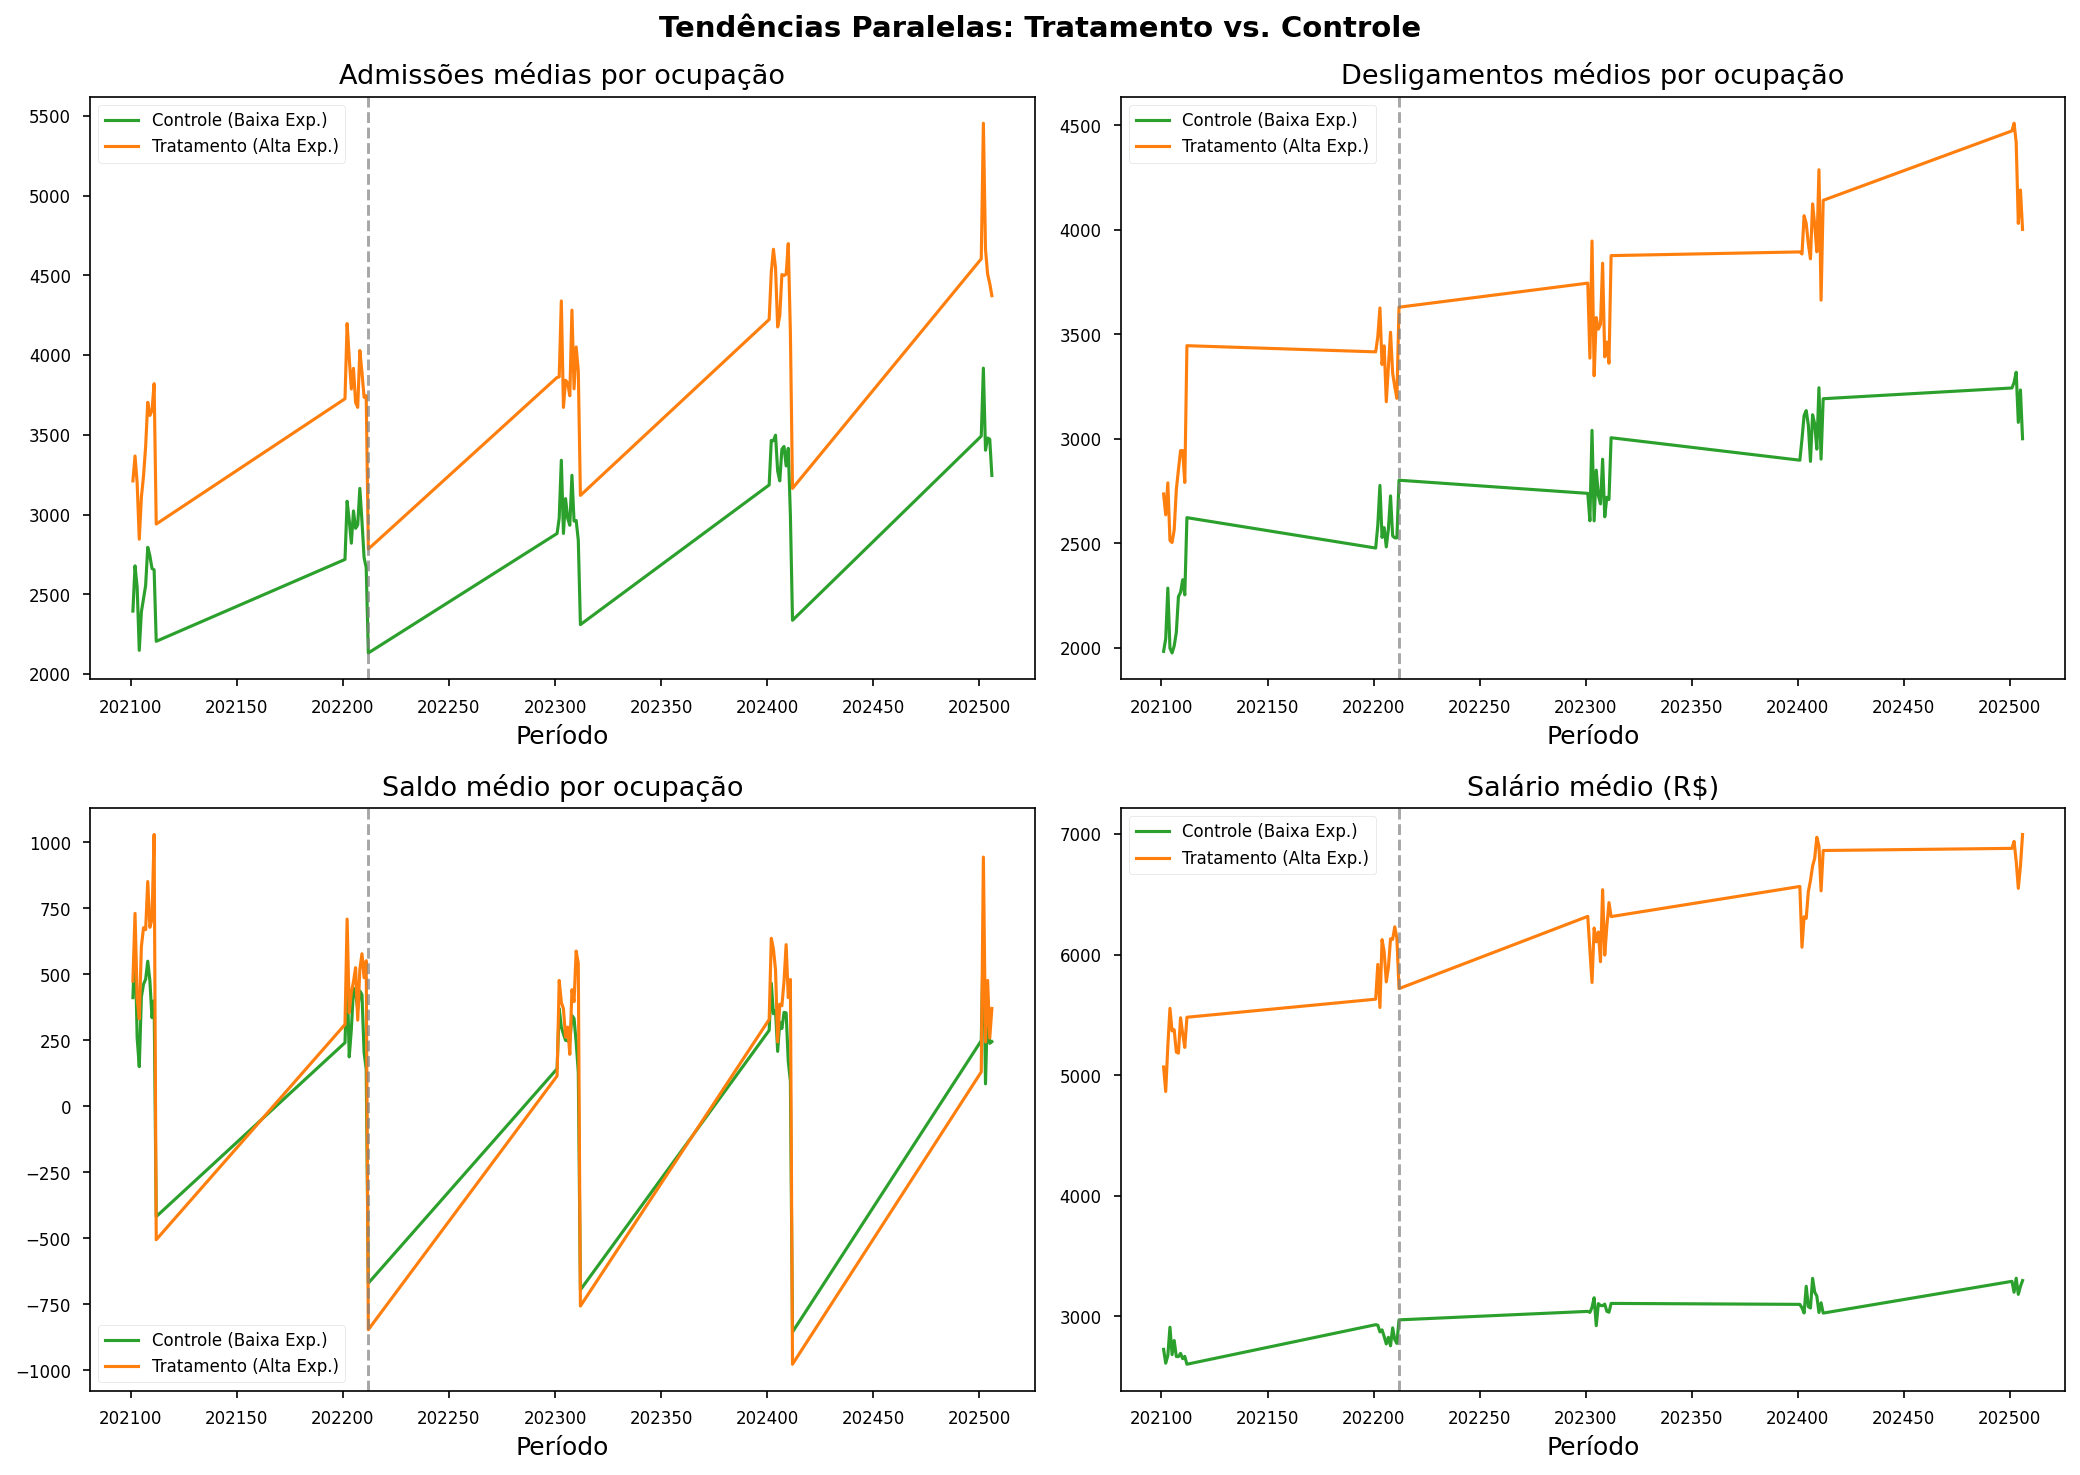

In [5]:
# Etapa 2b.4 — Tendências paralelas (visual)

ts_grupo = df.groupby(['periodo_num', 'alta_exp']).agg(
    admissoes_total=('admissoes', 'sum'), desligamentos_total=('desligamentos', 'sum'),
    saldo_total=('saldo', 'sum'), salario_medio=('salario_medio_adm', 'mean'),
    n_ocupacoes=('cbo_4d', 'nunique')).reset_index()
for col in ['admissoes_total', 'desligamentos_total', 'saldo_total']:
    ts_grupo[f'{col}_per_ocup'] = ts_grupo[col] / ts_grupo['n_ocupacoes']
ts_grupo['grupo'] = ts_grupo['alta_exp'].map({0: 'Controle (Baixa Exp.)', 1: 'Tratamento (Alta Exp.)'})

outcomes_plot = {'admissoes_total_per_ocup': 'Admissões médias por ocupação',
                 'desligamentos_total_per_ocup': 'Desligamentos médios por ocupação',
                 'saldo_total_per_ocup': 'Saldo médio por ocupação', 'salario_medio': 'Salário médio (R$)'}
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
evento_periodo = ANO_TRATAMENTO * 100 + MES_TRATAMENTO
for i, (var, title) in enumerate(outcomes_plot.items()):
    ax = axes.flat[i]
    for grupo in ['Controle (Baixa Exp.)', 'Tratamento (Alta Exp.)']:
        data = ts_grupo[ts_grupo['grupo']==grupo]
        color = COLORS['control'] if 'Controle' in grupo else COLORS['treated']
        ax.plot(data['periodo_num'], data[var], label=grupo, color=color, linewidth=1.5)
    ax.axvline(x=evento_periodo, color='gray', linestyle='--', alpha=0.7)
    ax.set_title(title); ax.set_xlabel('Período'); ax.legend(fontsize=8)
plt.suptitle('Tendências Paralelas: Tratamento vs. Controle', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(OUTPUTS_FIGURES / 'parallel_trends_all_outcomes.png', dpi=150, bbox_inches='tight')
plt.show()

### 5a. Estimação DiD principal

Seis modelos por outcome: (1) DiD básico, (2) com FE, (3) **PRINCIPAL** FE + controles 2d, (4) tratamento contínuo 2d, (5) robustez FE+controles 4d, (6) contínuo 4d. Erros clusterizados por ocupação (CBO 4d).

In [6]:
# Etapa 2b.5a — Estimação DiD principal

df_reg = df.copy()
for col in ['admissoes','desligamentos','saldo','ln_admissoes','ln_desligamentos','ln_salario_adm',
            'idade_media_adm','pct_mulher_adm','pct_superior_adm','post','alta_exp','exposure_score_2d','exposure_score_4d']:
    if col in df_reg.columns: df_reg[col] = pd.to_numeric(df_reg[col], errors='coerce')
df_reg['post_alta'] = df_reg['post'] * df_reg['alta_exp']
df_reg['post_exposure_2d'] = df_reg['post'] * df_reg['exposure_score_2d']
df_reg['post_alta_4d'] = df_reg['post'] * df_reg['alta_exp_4d']
df_reg['post_exposure_4d'] = df_reg['post'] * df_reg['exposure_score_4d']

def estimate_did(df_in, outcome, formula, label):
    try:
        model = pf.feols(formula, data=df_in, vcov=VCOV_SPEC)
        names = model.coef().index.tolist()
        did_name = [c for c in names if 'post' in c.lower() and ('alta' in c.lower() or 'exposure' in c.lower())]
        if not did_name: did_name = [names[0]]
        name = did_name[0]
        coef = float(model.coef().loc[name]); se = float(model.se().loc[name]); pval = float(model.pvalue().loc[name])
        stars = '***' if pval < 0.01 else '**' if pval < 0.05 else '*' if pval < 0.10 else ''
        return {'model': label, 'outcome': outcome, 'coef': coef, 'se': se, 'p_value': pval, 'stars': stars, 'n_obs': len(df_in), 'n_clusters': None}
    except Exception as e: print(f"  ERRO {label}/{outcome}: {e}"); return None

all_results = []
for outcome, label in OUTCOMES.items():
    if outcome not in df_reg.columns: continue
    df_out = df_reg[df_reg[outcome].notna()].copy()
    for r in [estimate_did(df_out, outcome, f"{outcome} ~ post_alta + post + alta_exp", "Model 1: Basic"),
               estimate_did(df_out, outcome, f"{outcome} ~ post_alta | cbo_4d + periodo", "Model 2: FE"),
               estimate_did(df_out, outcome, f"{outcome} ~ post_alta + idade_media_adm + pct_mulher_adm + pct_superior_adm | cbo_4d + periodo", "Model 3: FE + Controls (MAIN)"),
               estimate_did(df_out, outcome, f"{outcome} ~ post_exposure_2d + idade_media_adm + pct_mulher_adm + pct_superior_adm | cbo_4d + periodo", "Model 4: Continuous (2d)")]:
        if r: all_results.append(r)
    df_4d = df_out[df_out['exposure_score_4d'].notna()].copy()
    for r in [estimate_did(df_4d, outcome, f"{outcome} ~ post_alta_4d + idade_media_adm + pct_mulher_adm + pct_superior_adm | cbo_4d + periodo", "Model 5: FE + Controls (4d)"),
              estimate_did(df_4d, outcome, f"{outcome} ~ post_exposure_4d + idade_media_adm + pct_mulher_adm + pct_superior_adm | cbo_4d + periodo", "Model 6: Continuous (4d)")]:
        if r: all_results.append(r)

df_results = pd.DataFrame(all_results)
df_results.to_csv(OUTPUTS_TABLES / 'did_main_results.csv', index=False)
print("Model 3 (PRINCIPAL):")
print(df_results[df_results['model']=='Model 3: FE + Controls (MAIN)'][['outcome','coef','se','p_value','stars']].to_string(index=False))

Model 3 (PRINCIPAL):
            outcome       coef        se  p_value stars
       ln_admissoes  -0.027130  0.026402 0.304556      
   ln_desligamentos   0.019000  0.026814 0.478853      
              saldo -77.674731 69.625480 0.265017      
     ln_salario_adm  -0.065617  0.027789 0.018518    **
  ln_salario_mulher  -0.044537  0.036202 0.219064      
   ln_salario_homem   0.003889  0.026967 0.885390      
   ln_salario_jovem  -0.133735  0.052203 0.010644    **
ln_salario_naojovem   0.002496  0.027484 0.927677      
  ln_salario_branco  -0.028496  0.035817 0.426566      
   ln_salario_negro   0.110582  0.067872 0.103757      
ln_salario_superior  -0.077509  0.040513 0.056178     *
   ln_salario_medio  -0.084545  0.031741 0.007930   ***
ln_admissoes_mulher  -0.046679  0.026165 0.074905     *
 ln_admissoes_homem  -0.034969  0.026214 0.182701      
 ln_admissoes_jovem  -0.055804  0.028659 0.051962     *
 ln_admissoes_negro  -0.003190  0.027197 0.906666      


### 5b. Checkpoint — Resultados DiD

Resumo dos resultados principais (Model 3) e robustez (Model 5), consistência 2d vs 4d.

In [7]:
# Etapa 2b.5b — Checkpoint

main_results = df_results[df_results['model'] == 'Model 3: FE + Controls (MAIN)']
rob_4d = df_results[df_results['model'] == 'Model 5: FE + Controls (4d)']
print("Model 3 (2d):"); [print(f"  {OUTCOMES.get(r['outcome'],r['outcome'])}: β={r['coef']:.4f}{r.get('stars','')} (p={r['p_value']:.3f})") for _,r in main_results.iterrows()]
print("Model 5 (4d):"); [print(f"  {OUTCOMES.get(r['outcome'],r['outcome'])}: β={r['coef']:.4f}{r.get('stars','')} (p={r['p_value']:.3f})") for _,r in rob_4d.iterrows()]
print("Consistência 2d vs 4d:")
for outcome in OUTCOMES:
    r2 = main_results[main_results['outcome']==outcome]; r4 = rob_4d[rob_4d['outcome']==outcome]
    if len(r2)>0 and len(r4)>0: print(f"  {outcome}: {'✓ mesma direção' if (r2.iloc[0]['coef']*r4.iloc[0]['coef'])>0 else '⚠ opostas'} (2d: {r2.iloc[0]['coef']:.4f}, 4d: {r4.iloc[0]['coef']:.4f})")

Model 3 (2d):
  Log(Admissões): β=-0.0271 (p=0.305)
  Log(Desligamentos): β=0.0190 (p=0.479)
  Saldo Líquido: β=-77.6747 (p=0.265)
  Log(Salário Admissão): β=-0.0656** (p=0.019)
  Log(Salário Mulheres): β=-0.0445 (p=0.219)
  Log(Salário Homens): β=0.0039 (p=0.885)
  Log(Salário Jovens): β=-0.1337** (p=0.011)
  Log(Salário Não-Jovens): β=0.0025 (p=0.928)
  Log(Salário Brancos): β=-0.0285 (p=0.427)
  Log(Salário Negros): β=0.1106 (p=0.104)
  Log(Salário Superior): β=-0.0775* (p=0.056)
  Log(Salário Médio): β=-0.0845*** (p=0.008)
  Log(Admissões Mulheres): β=-0.0467* (p=0.075)
  Log(Admissões Homens): β=-0.0350 (p=0.183)
  Log(Admissões Jovens): β=-0.0558* (p=0.052)
  Log(Admissões Negros): β=-0.0032 (p=0.907)
Model 5 (4d):
  Log(Admissões): β=-0.0247 (p=0.353)
  Log(Desligamentos): β=0.0196 (p=0.456)
  Saldo Líquido: β=-142.4436* (p=0.053)
  Log(Salário Admissão): β=-0.0679** (p=0.013)
  Log(Salário Mulheres): β=-0.0484 (p=0.227)
  Log(Salário Homens): β=-0.0157 (p=0.554)
  Log(Salário J

### 6. Event study

Estimação com dummies de interação período × tratamento. O **período de referência é t = −1** (mês antes do ChatGPT, Nov/2022), de modo que todos os demais coeficientes são interpretados em relação a esse mês. **Binning dos extremos** (t ≤ −12 e t ≥ 24) reduz ruído nas pontas da janela. Coeficientes pré-tratamento não significativos e próximos de zero sustentam a hipótese de tendências paralelas.

In [8]:
# Etapa 2b.6 — Event study (dummies + estimação)

BIN_MIN, BIN_MAX, ref_t = -12, 24, -1
df_es = df_reg.copy()
df_es['t_binned'] = df_es['tempo_relativo_meses'].clip(lower=BIN_MIN, upper=BIN_MAX)

def _dname(t): return f"did_tm{-t}" if t < 0 else f"did_t{t}"
did_vars = []; t_to_name = {}
for t in sorted(df_es['t_binned'].unique()):
    if t == ref_t: continue
    dname = _dname(t); t_to_name[t] = dname
    df_es[dname] = ((df_es['t_binned']==t) & (df_es['alta_exp']==1)).astype(int)
    did_vars.append(dname)

event_study_results = {}
for outcome, label in OUTCOMES.items():
    if outcome not in df_es.columns: continue
    df_out = df_es[df_es[outcome].notna()].copy()
    formula = f"{outcome} ~ {' + '.join(did_vars)} + idade_media_adm + pct_mulher_adm + pct_superior_adm | cbo_4d + periodo"
    try:
        model = pf.feols(formula, data=df_out, vcov=VCOV_SPEC)
        idx = model.coef().index.tolist()
        coefs = []
        for t in sorted(df_es['t_binned'].unique()):
            if t == ref_t: coefs.append({'t':t,'coef':0,'se':0,'p_value':np.nan,'is_reference':True,'is_pre':t<0})
            else:
                dname = t_to_name.get(t, _dname(t))
                if dname in idx: coefs.append({'t':t,'coef':float(model.coef().loc[dname]),'se':float(model.se().loc[dname]),'p_value':float(model.pvalue().loc[dname]),'is_reference':False,'is_pre':t<0})
        df_c = pd.DataFrame(coefs); df_c['ci_low'] = df_c['coef'] - 1.96*df_c['se']; df_c['ci_high'] = df_c['coef'] + 1.96*df_c['se']
        event_study_results[outcome] = df_c
        df_c.to_csv(OUTPUTS_TABLES / f'event_study_{outcome}.csv', index=False)
    except Exception as e: print(f"  ERRO {outcome}: {e}")
print(f"Event study salvo para {len(event_study_results)} outcomes.")

Event study salvo para 16 outcomes.


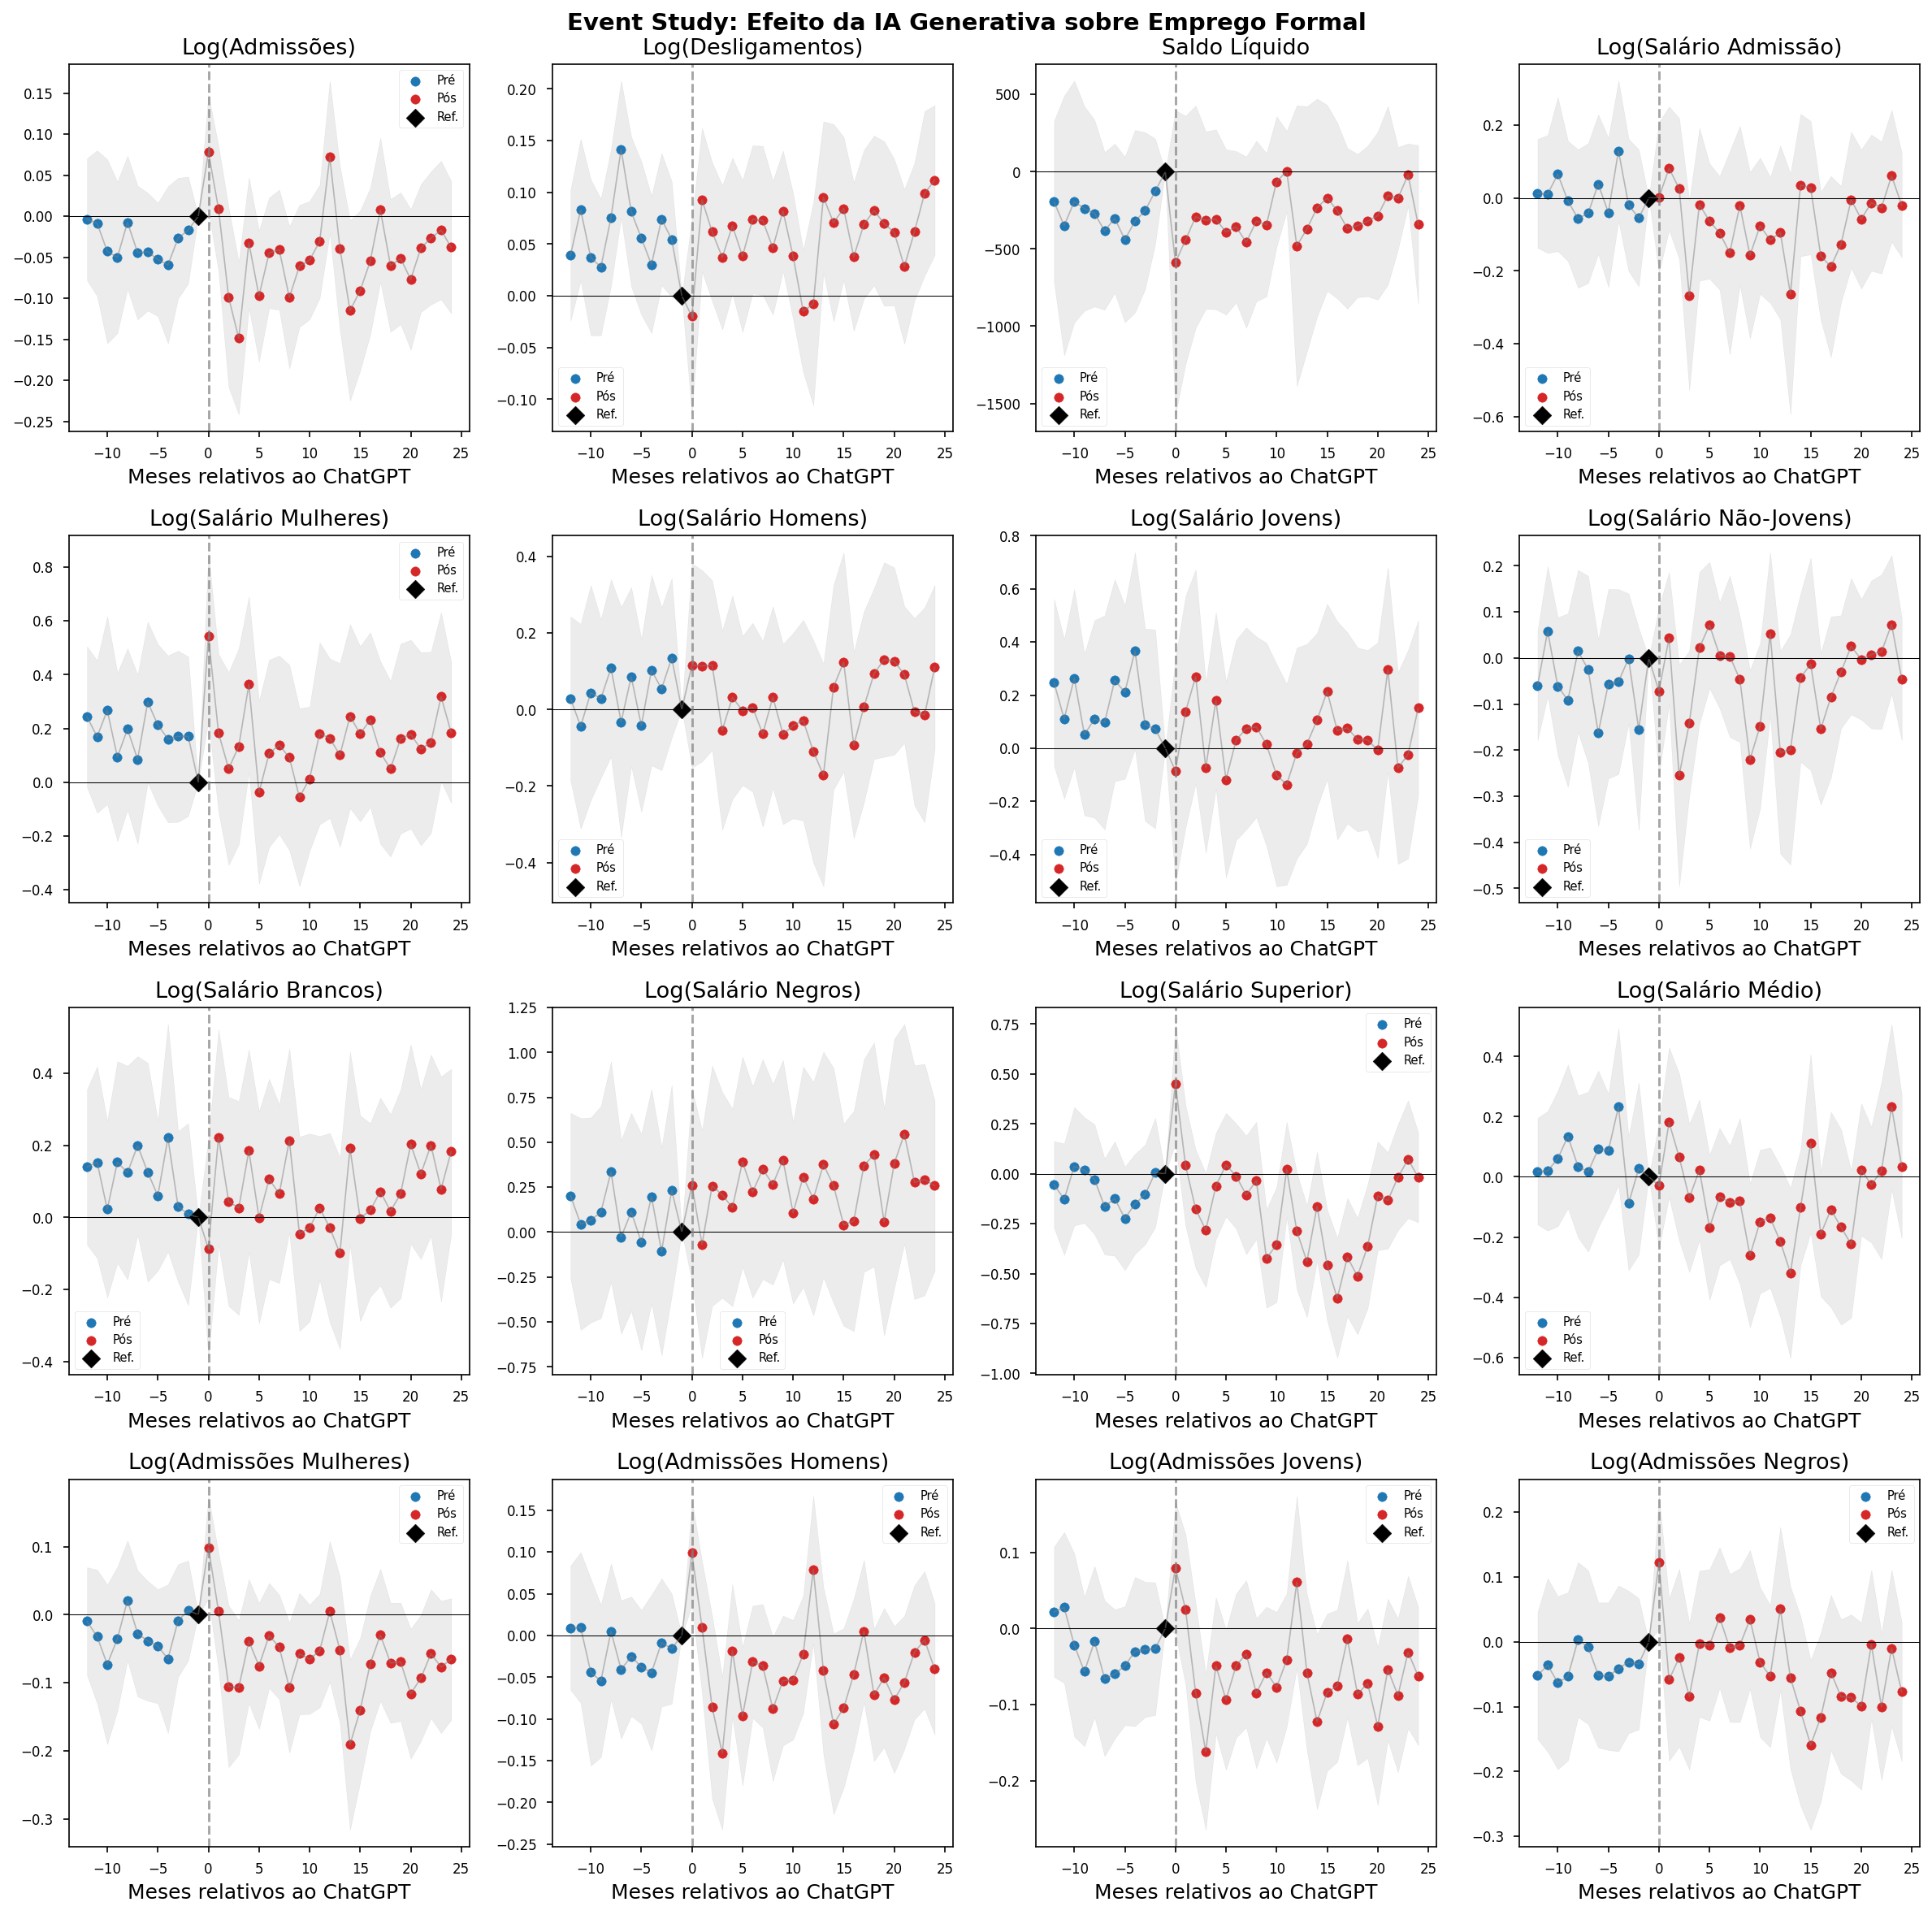

In [10]:
# Etapa 2b.6 (cont.) — Gráficos do event study

outcomes_with_results = [(o, OUTCOMES[o]) for o in OUTCOMES if o in event_study_results]
n_plot = len(outcomes_with_results)
n_cols = 4
n_rows = max(1, (n_plot + n_cols - 1) // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))
axes = np.atleast_1d(axes).flat
for j in range(n_plot, len(axes)):
    axes[j].set_visible(False)
for i, (outcome, label) in enumerate(outcomes_with_results):
    ax = axes[i]
    df_c = event_study_results[outcome]
    ax.fill_between(df_c['t'], df_c['ci_low'], df_c['ci_high'], alpha=0.15, color='gray')
    pre = df_c[df_c['is_pre'] & ~df_c['is_reference']]; post = df_c[~df_c['is_pre'] & ~df_c['is_reference']]; ref = df_c[df_c['is_reference']]
    ax.scatter(pre['t'], pre['coef'], color=COLORS['pre'], s=30, label='Pré'); ax.scatter(post['t'], post['coef'], color=COLORS['post'], s=30, label='Pós')
    ax.scatter(ref['t'], ref['coef'], color='black', s=60, marker='D', label='Ref.')
    ax.plot(df_c['t'], df_c['coef'], color='gray', linewidth=0.8, alpha=0.5)
    ax.axhline(y=0, color='black', linewidth=0.5); ax.axvline(x=0, color='gray', linestyle='--', alpha=0.7)
    ax.set_title(label); ax.set_xlabel('Meses relativos ao ChatGPT'); ax.legend(fontsize=7)
plt.suptitle('Event Study: Efeito da IA Generativa sobre Emprego Formal', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.savefig(OUTPUTS_FIGURES / 'event_study_all_outcomes.png', dpi=150, bbox_inches='tight'); plt.show()

### 6b. Teste formal de tendências paralelas

H₀: todos os coeficientes pré-tratamento são conjuntamente zero. Se rejeitarmos (ou se vários pré forem individualmente significativos), há preocupação com a hipótese de tendências paralelas.

In [11]:
# Etapa 2b.6b — Teste formal tendências paralelas

results_pt = []
for outcome, label in OUTCOMES.items():
    if outcome not in event_study_results: continue
    df_c = event_study_results[outcome]
    pre_coefs = df_c[df_c['is_pre'] & ~df_c['is_reference']]
    if len(pre_coefs)==0: continue
    n_sig = (pre_coefs['p_value'] < 0.05).sum()
    se_nz = pre_coefs['se'].replace(0, np.nan); max_t = (pre_coefs['coef']/se_nz).abs().max() if se_nz.notna().any() else 0
    t_stats = (pre_coefs['coef']/pre_coefs['se'].replace(0,np.nan)).fillna(0).values; n_pre = len(t_stats)
    p_joint = 1 - stats.chi2.cdf(np.mean(t_stats**2)*n_pre, df=n_pre)
    status = 'PARALELAS' if n_sig==0 and p_joint>0.10 else 'PREOCUPAÇÃO'
    results_pt.append({'Outcome': label, 'N coefs pré': n_pre, 'Sig. (p<0.05)': int(n_sig), 'p-valor conjunto': f'{p_joint:.3f}', 'Status': status})
    print(f"{label}: {n_sig} pré sig., p_joint={p_joint:.3f} → {status}")
pd.DataFrame(results_pt).to_csv(OUTPUTS_TABLES / 'parallel_trends_test.csv', index=False)

Log(Admissões): 0 pré sig., p_joint=0.639 → PARALELAS
Log(Desligamentos): 5 pré sig., p_joint=0.000 → PREOCUPAÇÃO
Saldo Líquido: 0 pré sig., p_joint=0.396 → PARALELAS
Log(Salário Admissão): 0 pré sig., p_joint=0.985 → PARALELAS
Log(Salário Mulheres): 0 pré sig., p_joint=0.073 → PREOCUPAÇÃO
Log(Salário Homens): 0 pré sig., p_joint=0.958 → PARALELAS
Log(Salário Jovens): 0 pré sig., p_joint=0.265 → PARALELAS
Log(Salário Não-Jovens): 0 pré sig., p_joint=0.696 → PARALELAS
Log(Salário Brancos): 0 pré sig., p_joint=0.516 → PARALELAS
Log(Salário Negros): 0 pré sig., p_joint=0.983 → PARALELAS
Log(Salário Superior): 0 pré sig., p_joint=0.657 → PARALELAS
Log(Salário Médio): 0 pré sig., p_joint=0.825 → PARALELAS
Log(Admissões Mulheres): 0 pré sig., p_joint=0.853 → PARALELAS
Log(Admissões Homens): 0 pré sig., p_joint=0.884 → PARALELAS
Log(Admissões Jovens): 0 pré sig., p_joint=0.696 → PARALELAS
Log(Admissões Negros): 0 pré sig., p_joint=0.894 → PARALELAS


### 7. Análise de heterogeneidade (Triple-DiD)

Testar se o efeito da IA é heterogêneo por composição das admissões: idade (jovem ≤30), gênero (% mulher > mediana), educação (% superior > mediana). O coeficiente da tripla interação (Post × AltaExp × Grupo) captura o efeito diferencial para o subgrupo.

In [12]:
# Etapa 2b.7 — Heterogeneidade (Triple-DiD)

df_het = df_reg.copy()
pre_mask = df_het['post']==0
med_mulher = df_het.loc[pre_mask, 'pct_mulher_adm'].median(); med_educ = df_het.loc[pre_mask, 'pct_superior_adm'].median()
df_het['jovem_adm'] = (df_het['idade_media_adm'] <= 30).astype(int)
df_het['feminino_adm'] = (df_het['pct_mulher_adm'] > med_mulher).astype(int)
df_het['alta_educ_adm'] = (df_het['pct_superior_adm'] > med_educ).astype(int)

HET_GROUPS = {'jovem_adm': 'Idade (jovem ≤30)', 'feminino_adm': 'Gênero (feminino)', 'alta_educ_adm': 'Educação (superior)'}
results_het = []
for group_var, group_label in HET_GROUPS.items():
    df_het['post_alta'] = df_het['post']*df_het['alta_exp']; df_het['post_group'] = df_het['post']*df_het[group_var]
    df_het['alta_group'] = df_het['alta_exp']*df_het[group_var]; df_het['post_alta_group'] = df_het['post']*df_het['alta_exp']*df_het[group_var]
    for outcome, out_label in OUTCOMES.items():
        if outcome not in df_het.columns: continue
        try:
            model = pf.feols(f"{outcome} ~ post_alta_group + post_alta + post_group + alta_group + idade_media_adm + pct_mulher_adm + pct_superior_adm | cbo_4d + periodo", data=df_het[df_het[outcome].notna()], vcov=VCOV_SPEC)
            if 'post_alta_group' not in model.coef().index: continue
            main_c = float(model.coef().loc['post_alta']); inter_c = float(model.coef().loc['post_alta_group']); inter_p = float(model.pvalue().loc['post_alta_group'])
            results_het.append({'outcome': outcome, 'outcome_label': out_label, 'group': group_label, 'main_effect': main_c, 'interaction': inter_c, 'interaction_pval': inter_p})
            if inter_p < 0.10: print(f"  {out_label} × {group_label}: β_inter = {inter_c:.4f} (p={inter_p:.3f})")
        except Exception as e: pass
df_het_results = pd.DataFrame(results_het)
df_het_results.to_csv(OUTPUTS_TABLES / 'heterogeneity_triple_did.csv', index=False)
print("Heterogeneidade salva.")

  Log(Salário Admissão) × Idade (jovem ≤30): β_inter = -0.3235 (p=0.001)
  Log(Salário Homens) × Idade (jovem ≤30): β_inter = -0.2393 (p=0.012)
  Log(Salário Brancos) × Idade (jovem ≤30): β_inter = -0.1428 (p=0.097)
  Log(Salário Negros) × Idade (jovem ≤30): β_inter = -0.3994 (p=0.002)
  Log(Salário Superior) × Idade (jovem ≤30): β_inter = 0.1452 (p=0.090)
  Log(Salário Médio) × Idade (jovem ≤30): β_inter = -0.2012 (p=0.022)
  Log(Admissões Mulheres) × Idade (jovem ≤30): β_inter = 0.1158 (p=0.051)
  Log(Salário Homens) × Gênero (feminino): β_inter = -0.1008 (p=0.085)
  Log(Salário Jovens) × Gênero (feminino): β_inter = 0.2747 (p=0.035)
  Log(Admissões) × Educação (superior): β_inter = -0.1462 (p=0.050)
  Log(Salário Superior) × Educação (superior): β_inter = -0.6412 (p=0.000)
  Log(Admissões Homens) × Educação (superior): β_inter = -0.1295 (p=0.087)
  Log(Admissões Jovens) × Educação (superior): β_inter = -0.1484 (p=0.062)
  Log(Admissões Negros) × Educação (superior): β_inter = -0.126

### 8. Testes de robustez

Cinco testes: (1) **Cutoffs alternativos** (top 10%, 25%, mediana) — espera-se mesma direção dos efeitos. (2) **Placebo temporal** (evento fictício Dez/2021, só com dados pré-reais): o coeficiente deve ser não significativo; significância indicaria efeitos espúrios. (3) **Exclusão de TI** (CBO 21xx) — resultado principal deve permanecer estável. (4) **Tendências diferenciais no pré** (trend × tratamento): coeficiente não significativo apoia tendências paralelas. (5) **Crosswalk 2d vs 4d** — mesma direção e magnitude similar reforçam robustez.

In [13]:
# Etapa 2b.8 — Testes de robustez (resumo; código completo nos scripts)

# Os 5 testes são executados em notebook/scripts/etapa_2b/10_robustness.py
# Resultados salvos em outputs/tables/robustness_results.csv
rob_path = OUTPUTS_TABLES / 'robustness_results.csv'
if rob_path.exists():
    df_robust = pd.read_csv(rob_path)
    for tt in df_robust['test_type'].unique():
        sub = df_robust[df_robust['test_type']==tt]
        n_sig = (sub['p_value'] < 0.10).sum()
        print(f"  {tt}: {n_sig}/{len(sub)} significativos (p<0.10)")
else:
    print("Execute o script 10_robustness.py para gerar robustness_results.csv")

# Robustez: cluster em cbo_2d (gerado por 04_did_main.py)
rob2_path = OUTPUTS_TABLES / 'did_robustez_cbo2d.csv'
if rob2_path.exists():
    df_cbo2d = pd.read_csv(rob2_path)
    print("\nRobustez (cluster cbo_2d):")
    print(df_cbo2d[['outcome', 'coef', 'se', 'p_value', 'stars']].to_string(index=False))
else:
    print("\nExecute 04_did_main.py para gerar did_robustez_cbo2d.csv")

  Alternative Cutoff: 5/16 significativos (p<0.10)
  Placebo: 0/4 significativos (p<0.10)
  Excl. TI: 1/4 significativos (p<0.10)
  Differential Trends: 0/4 significativos (p<0.10)
  Crosswalk 4d: 2/4 significativos (p<0.10)

Robustez (cluster cbo_2d):
       outcome      coef       se  p_value stars
ln_salario_adm -0.063085 0.036362 0.089601     *


### 9. Tabelas LaTeX

Tabela principal (Model 3) para inclusão na dissertação.

In [14]:
# Etapa 2b.9 - Tabela LaTeX

main = df_results[df_results['model'] == 'Model 3: FE + Controls (MAIN)']
outcomes_order = ['ln_admissoes', 'ln_desligamentos', 'saldo', 'ln_salario_adm']
col_names = ['(1) Log(Adm.)', '(2) Log(Desl.)', '(3) Saldo', '(4) Log(Salário)']

# Representação visual no notebook
coefs = []; ses = []
for o in outcomes_order:
    row = main[main['outcome']==o]
    if len(row) > 0:
        r = row.iloc[0]
        coefs.append(f"{r['coef']:.4f}{r.get('stars', '')}")
        ses.append(f"({r['se']:.4f})")
    else:
        coefs.append("—"); ses.append("—")
tab_vis = pd.DataFrame([coefs, ses], index=["Post × Alta Exp.", "Erro padrão"], columns=col_names)
print("Tabela principal (Model 3) — visualização:")
display(tab_vis)
print("\nFE Ocupação e FE Período: ✓ em todas as colunas. * p<0,10 ** p<0,05 *** p<0,01.")

coef_line = r"Post $\times$ Alta Exp."; se_line = ""
for o in outcomes_order:
    row = main[main['outcome']==o]
    if len(row)>0: r=row.iloc[0]; coef_line += f" & {r['coef']:.4f}{r.get('stars','')}"; se_line += f" & ({r['se']:.4f})"
    else: coef_line += " & —"; se_line += " & —"
lines = [r"\begin{table}[htbp]", r"\centering", r"\caption{Efeitos DiD sobre Emprego Formal: Resultados Principais}", r"\label{tab:did_main}", r"\begin{tabular}{lcccc}", r"\toprule", r" & (1) Log(Adm.) & (2) Log(Desl.) & (3) Saldo & (4) Log(Salário) \\", r"\midrule", coef_line + r" \\", se_line + r" \\", r"\midrule", r"FE Ocupação & \checkmark & \checkmark & \checkmark & \checkmark \\", r"FE Período & \checkmark & \checkmark & \checkmark & \checkmark \\", r"\bottomrule", r"\end{tabular}", r"\end{table}"]
latex_text = '\n'.join(lines)
with open(OUTPUTS_TABLES / 'table_did_main.tex', 'w') as f: f.write(latex_text)
print("Tabela LaTeX salva em outputs/tables/table_did_main.tex")

# Mostrar LaTeX no notebook (para copiar na dissertação)
from IPython.display import display, Markdown
display(Markdown("**Código LaTeX (para copiar na dissertação):**"))
display(Markdown("```latex\n" + latex_text + "\n```"))

Tabela principal (Model 3) — visualização:


,(1) Log(Adm.),(2) Log(Desl.),(3) Saldo,(4) Log(Salário)
Post × Alta Exp.,-0.0271,0.0190,-77.6747,-0.0656**
Erro padrão,(0.0264),(0.0268),(69.6255),(0.0278)



FE Ocupação e FE Período: ✓ em todas as colunas. * p<0,10 ** p<0,05 *** p<0,01.
Tabela LaTeX salva em outputs/tables/table_did_main.tex


**Código LaTeX (para copiar na dissertação):**

```latex
\begin{table}[htbp]
\centering
\caption{Efeitos DiD sobre Emprego Formal: Resultados Principais}
\label{tab:did_main}
\begin{tabular}{lcccc}
\toprule
 & (1) Log(Adm.) & (2) Log(Desl.) & (3) Saldo & (4) Log(Salário) \\
\midrule
Post $\times$ Alta Exp. & -0.0271 & 0.0190 & -77.6747 & -0.0656** \\
 & (0.0264) & (0.0268) & (69.6255) & (0.0278) \\
\midrule
FE Ocupação & \checkmark & \checkmark & \checkmark & \checkmark \\
FE Período & \checkmark & \checkmark & \checkmark & \checkmark \\
\bottomrule
\end{tabular}
\end{table}
```

### 10. Síntese e conclusões

Resumo dos achados, comparação com a literatura e limitações.

In [15]:
# Etapa 2b.10 — Síntese

print("RESULTADOS DiD PRINCIPAIS (Model 3)")
for _, r in df_results[df_results['model']=='Model 3: FE + Controls (MAIN)'].iterrows():
    print(f"  {OUTCOMES.get(r['outcome'],r['outcome'])}: β = {r['coef']:.4f}{r.get('stars','')} (p = {r['p_value']:.3f})")
print("\nComparação PNAD: outcomes diferentes (CAGED = fluxos; PNAD = estoques). Ver texto da dissertação.")

RESULTADOS DiD PRINCIPAIS (Model 3)
  Log(Admissões): β = -0.0271 (p = 0.305)
  Log(Desligamentos): β = 0.0190 (p = 0.479)
  Saldo Líquido: β = -77.6747 (p = 0.265)
  Log(Salário Admissão): β = -0.0656** (p = 0.019)
  Log(Salário Mulheres): β = -0.0445 (p = 0.219)
  Log(Salário Homens): β = 0.0039 (p = 0.885)
  Log(Salário Jovens): β = -0.1337** (p = 0.011)
  Log(Salário Não-Jovens): β = 0.0025 (p = 0.928)
  Log(Salário Brancos): β = -0.0285 (p = 0.427)
  Log(Salário Negros): β = 0.1106 (p = 0.104)
  Log(Salário Superior): β = -0.0775* (p = 0.056)
  Log(Salário Médio): β = -0.0845*** (p = 0.008)
  Log(Admissões Mulheres): β = -0.0467* (p = 0.075)
  Log(Admissões Homens): β = -0.0350 (p = 0.183)
  Log(Admissões Jovens): β = -0.0558* (p = 0.052)
  Log(Admissões Negros): β = -0.0032 (p = 0.907)

Comparação PNAD: outcomes diferentes (CAGED = fluxos; PNAD = estoques). Ver texto da dissertação.


### Limitações desta etapa

1. **Emprego formal apenas:** CAGED cobre só CLT; informalidade não capturada.
2. **Fluxos vs. estoques:** Redução em admissões pode refletir menor rotatividade ou menor demanda.
3. **Difusão gradual da IA:** Tratamento assume impacto abrupto em Nov/2022; na prática a difusão é gradual.
4. **Janela temporal:** Jan/2021–Jun/2025 (54 meses); 2025 limitado a 6 meses.
5. **Crosswalk 2d/4d:** Agregação perde variação; crosswalk 4d com fallback pode ter erro de medição.
6. **Índice global:** ILO calibrado globalmente; pode não capturar especificidades brasileiras.
7. **Outliers salariais:** Winsorização P1/P99 aplicada.

### Checklist de entregáveis

- `outputs/tables/balance_table_pre.csv`
- `outputs/figures/parallel_trends_all_outcomes.png`
- `outputs/tables/did_main_results.csv`
- `outputs/tables/event_study_*.csv`, `outputs/figures/event_study_all_outcomes.png`
- `outputs/tables/parallel_trends_test.csv`
- `outputs/tables/heterogeneity_triple_did.csv`
- `outputs/tables/robustness_results.csv`
- `outputs/tables/table_did_main.tex`